In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
import argparse
from datetime import datetime
import matplotlib.pyplot as plt  # 【新增】引入绘图库

from model.SeaNet_models import SeaNet
from data import get_loader
from utils import clip_gradient, adjust_lr
import pytorch_iou

# --- 设备配置 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)

# --- 参数设置 ---
parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=50, help='epoch number')
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--batchsize', type=int, default=2, help='training batch size')
parser.add_argument('--trainsize', type=int, default=288, help='training dataset size')
parser.add_argument('--clip', type=float, default=0.5, help='gradient clipping margin')
parser.add_argument('--decay_rate', type=float, default=0.1, help='decay rate of learning rate')
parser.add_argument('--decay_epoch', type=int, default=30, help='every n epochs decay learning rate')
opt = parser.parse_args(args=[])

# --- 模型与优化器 ---
model = SeaNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

image_root = 'datasets/Image-train/'
gt_root = 'datasets/GT-train/'
train_loader = get_loader(image_root, gt_root, batchsize=opt.batchsize, trainsize=opt.trainsize)
total_step = len(train_loader)

# --- 损失函数 ---
CE = torch.nn.BCEWithLogitsLoss().to(device)
MSE = torch.nn.MSELoss().to(device)
IOU = pytorch_iou.IOU(size_average=True).to(device)

# 【新增】用于记录训练数据的列表
history = {
    'total_loss': [],
    'loss1': [],
    'loss2': [],
    'loss3': [],
    'loss4': []
}

def train(train_loader, model, optimizer, epoch):
    model.train()
    
    # 【新增】用于累加一个 epoch 内的 loss，方便计算平均值
    epoch_loss_sum = 0
    epoch_loss1_sum = 0
    epoch_loss2_sum = 0
    epoch_loss3_sum = 0
    epoch_loss4_sum = 0
    
    for i, pack in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        
        images, gts = pack
        images = images.to(device)
        gts = gts.to(device)

        s12, s34, s5, s12_sig, s34_sig, s5_sig, edge1, edge2 = model(images)

        loss1 = CE(s12, gts) + IOU(s12_sig, gts)
        loss2 = CE(s34, gts) + IOU(s34_sig, gts)
        loss3 = CE(s5, gts) + IOU(s5_sig, gts)
        loss4 = MSE(edge1, edge2)

        loss = loss1 + loss2 + loss3 + 0.5 * loss4

        loss.backward()

        clip_gradient(optimizer, opt.clip)
        optimizer.step()
        
        # 累加 Loss (使用 .item() 获取数值)
        epoch_loss_sum += loss.item()
        epoch_loss1_sum += loss1.item()
        epoch_loss2_sum += loss2.item()
        epoch_loss3_sum += loss3.item()
        epoch_loss4_sum += loss4.item()

        if i % 20 == 0 or i == total_step:
            print(
                '{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], LR: {:.6f}, Loss: {:.4f}'.
                format(datetime.now(), epoch, opt.epoch, i, total_step,
                       optimizer.param_groups[0]['lr'], loss.item()))

    save_path = 'models/SeaNet/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if (epoch) % 5 == 0:
        torch.save(model.state_dict(), os.path.join(save_path, f'SeaNet_epoch_{epoch}.pth'))

    # 【新增】返回本 Epoch 的平均 Loss
    return {
        'total': epoch_loss_sum / total_step,
        'l1': epoch_loss1_sum / total_step,
        'l2': epoch_loss2_sum / total_step,
        'l3': epoch_loss3_sum / total_step,
        'l4': epoch_loss4_sum / total_step
    }

print("Let's go!")
# --- 主循环 ---
for epoch in range(1, opt.epoch + 1):
    adjust_lr(optimizer, opt.lr, epoch, opt.decay_rate, opt.decay_epoch)
    
    # 获取当次 Epoch 的平均结果
    epoch_results = train(train_loader, model, optimizer, epoch)
    
    # 【新增】记录数据到列表
    history['total_loss'].append(epoch_results['total'])
    history['loss1'].append(epoch_results['l1'])
    history['loss2'].append(epoch_results['l2'])
    history['loss3'].append(epoch_results['l3'])
    history['loss4'].append(epoch_results['l4'])

# --- 【新增】画图代码 ---
print("Training finished.")

loading imagenet pretrained mobilenetv2
loaded imagenet pretrained mobilenetv2
Let's go!
decay_epoch: 30, Current_LR: 0.0001
2025-12-17 19:25:28.015291 Epoch [001/050], Step [0020/0300], LR: 0.000100, Loss: 5.0133
2025-12-17 19:25:29.249331 Epoch [001/050], Step [0040/0300], LR: 0.000100, Loss: 4.8406
2025-12-17 19:25:30.330326 Epoch [001/050], Step [0060/0300], LR: 0.000100, Loss: 4.0493
2025-12-17 19:25:31.430017 Epoch [001/050], Step [0080/0300], LR: 0.000100, Loss: 4.8230
2025-12-17 19:25:32.527041 Epoch [001/050], Step [0100/0300], LR: 0.000100, Loss: 4.5906
2025-12-17 19:25:33.613135 Epoch [001/050], Step [0120/0300], LR: 0.000100, Loss: 4.4299
2025-12-17 19:25:34.707898 Epoch [001/050], Step [0140/0300], LR: 0.000100, Loss: 4.0186
2025-12-17 19:25:35.807345 Epoch [001/050], Step [0160/0300], LR: 0.000100, Loss: 4.4645
2025-12-17 19:25:36.915610 Epoch [001/050], Step [0180/0300], LR: 0.000100, Loss: 3.3559
2025-12-17 19:25:38.022615 Epoch [001/050], Step [0200/0300], LR: 0.000100

Plotting results...
Loss curve saved as 'loss_curve.png'


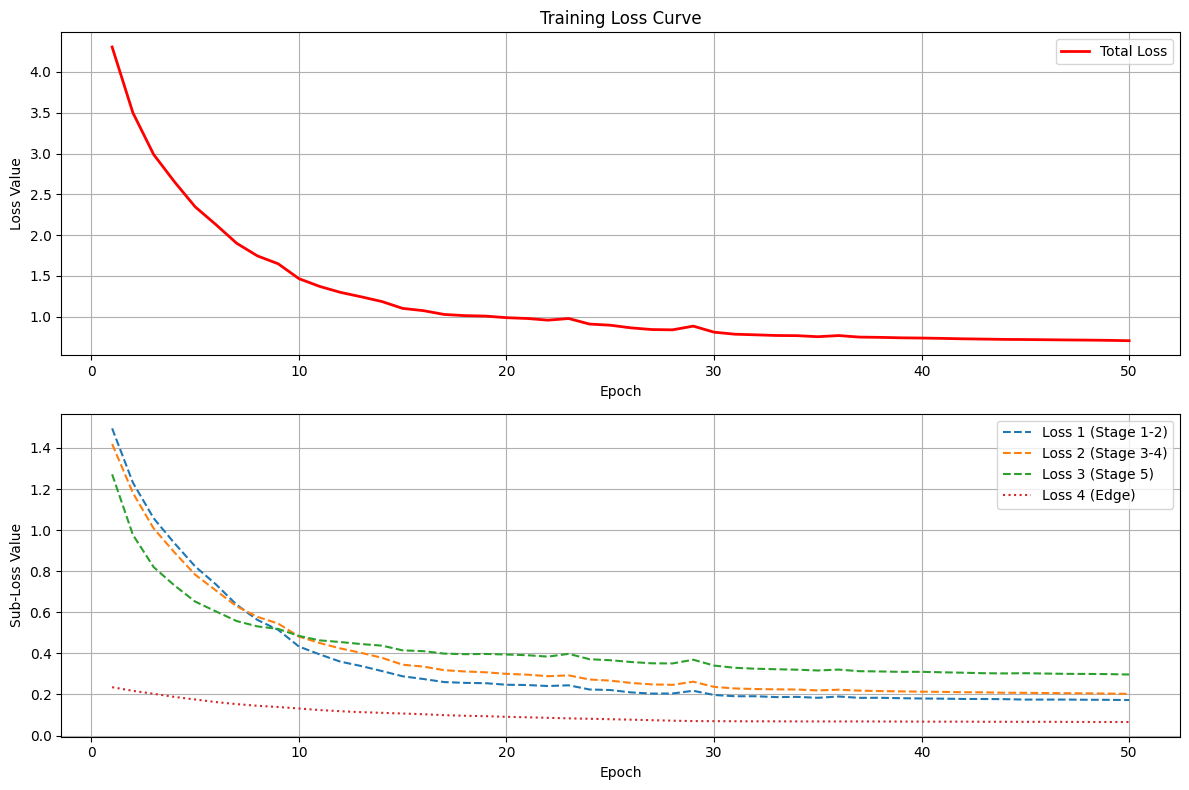

In [3]:
print("Plotting results...")
# 创建一个画布
plt.figure(figsize=(12, 8))

# 绘制总 Loss
plt.subplot(2, 1, 1) # 上半部分图
plt.plot(range(1, opt.epoch + 1), history['total_loss'], label='Total Loss', color='red', linewidth=2)
plt.title('Training Loss Curve')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()

# 绘制子 Loss (查看细节)
plt.subplot(2, 1, 2) # 下半部分图
plt.plot(range(1, opt.epoch + 1), history['loss1'], label='Loss 1 (Stage 1-2)', linestyle='--')
plt.plot(range(1, opt.epoch + 1), history['loss2'], label='Loss 2 (Stage 3-4)', linestyle='--')
plt.plot(range(1, opt.epoch + 1), history['loss3'], label='Loss 3 (Stage 5)', linestyle='--')
plt.plot(range(1, opt.epoch + 1), history['loss4'], label='Loss 4 (Edge)', linestyle=':')
plt.xlabel('Epoch')
plt.ylabel('Sub-Loss Value')
plt.grid(True)
plt.legend()

# 保存图片到本地
plt.tight_layout()
plt.savefig('loss_curve.png')
print("Loss curve saved as 'loss_curve.png'")

# 如果你在本地电脑运行（有图形界面），可以取消下面这行的注释来直接显示窗口
# plt.show()